In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
'''RNN - Regression model used to predict the number of voluntary separations, people who quit, by month. 
priliminary training shows perecent diffrence from actual values to be: +20 percent, -15 percent, on test set data''';

In [4]:
data = pd.read_csv('C:/Users/604070/Desktop/Files/RNN/rnn_data.csv', low_memory=False)
data.shape

(2073129, 28)

In [5]:
data.head()

,Unnamed: 0,AGELVLT,AGYSUBT,AGYT,AGYTYPT,COUNT,EFDATET,FYT,GSEGRD,LOCT,...,PPGRD,PPGROUPT,QTRT,SALARY,SALLVLT,TOAT,TOATYPT,WORKSCHT,WSTYPT,LABELS
0,0,25-29,AA00-ADMINISTRATIVE CONFERENCE OF THE UNITED S...,AA-ADMINISTRATIVE CONFERENCE OF THE UNITED STATES,Small Independent Agencies (less than 100 empl...,1,APR 2016,FY 2016,12,11-DISTRICT OF COLUMBIA,...,GS-12,Standard GSEG Pay Plans,APR-JUN 2016,77490,"$70,000 - $79,999",30-Excepted Service - Schedule A,Permanent,F - Full-time Nonseasonal,Full-time,0
1,1,25-29,AA00-ADMINISTRATIVE CONFERENCE OF THE UNITED S...,AA-ADMINISTRATIVE CONFERENCE OF THE UNITED STATES,Small Independent Agencies (less than 100 empl...,1,JUN 2016,FY 2016,12,11-DISTRICT OF COLUMBIA,...,GS-12,Standard GSEG Pay Plans,APR-JUN 2016,77490,"$70,000 - $79,999",30-Excepted Service - Schedule A,Permanent,F - Full-time Nonseasonal,Full-time,0
2,2,25-29,AA00-ADMINISTRATIVE CONFERENCE OF THE UNITED S...,AA-ADMINISTRATIVE CONFERENCE OF THE UNITED STATES,Small Independent Agencies (less than 100 empl...,1,APR 2012,FY 2012,12,11-DISTRICT OF COLUMBIA,...,GS-12,Standard GSEG Pay Plans,APR-JUN 2012,79864,"$70,000 - $79,999",30-Excepted Service - Schedule A,Permanent,F - Full-time Nonseasonal,Full-time,0
3,3,30-34,AA00-ADMINISTRATIVE CONFERENCE OF THE UNITED S...,AA-ADMINISTRATIVE CONFERENCE OF THE UNITED STATES,Small Independent Agencies (less than 100 empl...,1,MAR 2017,FY 2017,12,11-DISTRICT OF COLUMBIA,...,GS-12,Standard GSEG Pay Plans,JAN-MAR 2017,79720,"$70,000 - $79,999",30-Excepted Service - Schedule A,Permanent,F - Full-time Nonseasonal,Full-time,0
4,4,25-29,BG00-PENSION BENEFIT GUARANTY CORPORATION,BG-PENSION BENEFIT GUARANTY CORPORATION,Medium Independent Agencies (100-999 employees),1,OCT 2010,FY 2011,12,11-DISTRICT OF COLUMBIA,...,GS-12,Standard GSEG Pay Plans,OCT-DEC 2010,74872,"$70,000 - $79,999",30-Excepted Service - Schedule A,Permanent,F - Full-time Nonseasonal,Full-time,0


In [6]:
def pre_process(df):
    
    data = df
    
    data = data.iloc[:,1:]
    data['Year'] = data['EFDATET'].apply(lambda x: x[4:])
    data['Month'] = data['EFDATET'].apply(lambda x: x[:2])
    data['QTRT'] = data['QTRT'].apply(lambda x: x[:7])
    
    data_dummy = pd.get_dummies(data[['AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT', 'COUNT', 'FYT',
       'GSEGRD', 'LOCT', 'LOCTYPT', 'LOS', 'LOSLVLT', 'OCCFAMT', 'OCCT',
       'OCCTYPT', 'PATCOT', 'PAYPLANT', 'PPGRD', 'PPGROUPT', 'QTRT', 'SALARY',
       'SALLVLT', 'TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT', 'LABELS',
       'Year', 'Month']])
    
    whole = pd.concat([data_dummy, data['EFDATET']], axis = 1)
   
    return whole 


def normalize(df):
    
    df = df.groupby('EFDATET').sum()
    
    df.index = pd.to_datetime(df.index)
    
    df.sort_values(by = 'EFDATET', ascending = True, inplace = True)
    
    mean_label = df['LABELS'].mean()
    std_label = df['LABELS'].std()
    
    for col in list(df.columns):
       
        mean, std = df[col].mean(), df[col].std()

        df.loc[:, col] = (df[col] - mean) /(std + .0001)      
        
    return df, mean_label, std_label   

def clean_data(data):
    
    df = data
    
    df.drop(['COUNT'], axis = 1, inplace = True)
    
    # move these into normalize function??
    
    '''df.index = pd.to_datetime(df.index)
    
    df.sort_values(by = 'EFDATET', ascending = True, inplace = True)'''
    
    df.reset_index(inplace = True)
    
    return df

In [7]:
processed_data = pre_process(data)

In [8]:
normal_data, mean, std = normalize(processed_data)

In [9]:
clean_data = clean_data(normal_data)

In [10]:
def batch(batch, t):
    if t == 0:
        y = batch['LABELS'].values
        X = X = batch.drop(['LABELS', 'EFDATET'], axis = 1).values
        
        return X,y
    
    y = batch['LABELS'].iloc[: -t].values
    
    X = batch.drop(['LABELS', 'EFDATET'], axis = 1).iloc[t :].values
    
    # returns np arrays
    return X, y

In [11]:
X, y = batch(clean_data, 0)

In [12]:
batch_size = 1
test_sz = .10

indx = round(len(X)*test_sz)

X.shape
X_train = X[:-indx,:]
y_train = y[:-indx]

X_test = X[-indx:,:]
y_test = y[-indx:]

In [13]:
def data_load(X, y, batch_size):

    X_sz = np.resize(X, (X.shape[0], 1, X.shape[1]))

    y_sz = np.resize(y, (y.shape[0], 1, 1))

    tensorData = TensorDataset(torch.from_numpy(X_sz).float(),torch.from_numpy(y_sz).float())

    dataloader = DataLoader(tensorData, batch_size = batch_size)
    
    return dataloader

In [14]:
train_dataloader = data_load(X_train, y_train, batch_size)

test_dataloader = data_load(X_test, y_test, batch_size)

In [15]:
class RNN(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim, layers):
        
        super(RNN,self).__init__()
               
        #model parameters 
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.layers = layers 
                
        #model layers        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, batch_first = True)
        
        self.fullyConnected = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_, hidden_):
        
        lstm_out, hidden_out = self.lstm(input_)
        
        out = self.fullyConnected(lstm_out)
        
        return out, hidden_out          

In [16]:
def forward_back_propagation(model, optimizer, loss_function, features, target, hidden_layer):
    
    """.zero_grad...sets gradients of all model parameters to zero."""
    
    model.zero_grad()
        
    output, hidden = model(features, hidden_layer)
     
    loss = loss_function(output, target)
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item(), hidden

In [17]:
def model_train(model, batch_size, optimizer, loss_function, epoch):
    
    losses = []
    
    '''.train() method sets mode... tells your model that you are training the model. 
    So effectively layers like dropout, batchnorm etc. which behave different 
    on the train and test procedures know what is going on and hence can behave accordingly.'''
    
    model.train()
    
    print("training for %d epochs" %epoch)
    for i in range(epoch):
        
        # initialize hidden state matrices 
        hidden = None
        
        # extract features and labels from train loader
                    
        
        for j, (input_, target) in enumerate(train_dataloader): 
            
            # call one pass...forward and backwards propagation 
            
            loss, hidden = forward_back_propagation(model, optimizer, loss_function, input_, target, hidden)
            
            hidden = hidden
            
            losses.append(loss)
            
            if i == 0:
                
                print('Epoch: ', i, 'Timesteps: '  , j, ' avg_loss', np.average(losses))
            
        print('Epoch: ', i, 'Timesteps: '  , j, ' avg_loss', np.average(losses))
                       
    return model     

In [18]:
lr = .0001
epoch_rnn = 300
batch_rnn = 1
hidden_nodes = 256
n_layers = 2

In [19]:
rnn_model = RNN(X.shape[1], 1, hidden_nodes, n_layers)

In [20]:
optim_adam = torch.optim.Adam(rnn_model.parameters(), lr = lr)

loss_function_MSE = torch.nn.MSELoss()

model_train(rnn_model, batch_rnn , optim_adam, loss_function_MSE, epoch_rnn)

training for 300 epochs
Epoch:  0 Timesteps:  0  avg_loss 0.4214843511581421
Epoch:  0 Timesteps:  1  avg_loss 1.0365428924560547
Epoch:  0 Timesteps:  2  avg_loss 0.9264901677767435
Epoch:  0 Timesteps:  3  avg_loss 0.7185108177363873
Epoch:  0 Timesteps:  4  avg_loss 0.714601394534111
Epoch:  0 Timesteps:  5  avg_loss 0.6516310249765714
Epoch:  0 Timesteps:  6  avg_loss 0.5684024138110024
Epoch:  0 Timesteps:  7  avg_loss 0.49827073636697605
Epoch:  0 Timesteps:  8  avg_loss 0.4430391100468114
Epoch:  0 Timesteps:  9  avg_loss 0.4511660850723274
Epoch:  0 Timesteps:  10  avg_loss 2.322023330012929
Epoch:  0 Timesteps:  11  avg_loss 2.2205689182446804
Epoch:  0 Timesteps:  12  avg_loss 2.0826498733636423
Epoch:  0 Timesteps:  13  avg_loss 1.995596009115356
Epoch:  0 Timesteps:  14  avg_loss 1.8697698110792165
Epoch:  0 Timesteps:  15  avg_loss 1.7604445027609472
Epoch:  0 Timesteps:  16  avg_loss 1.6807227568111984
Epoch:  0 Timesteps:  17  avg_loss 1.5922510731098656
Epoch:  0 Timest

Epoch:  73 Timesteps:  75  avg_loss 0.04005833387615902
Epoch:  74 Timesteps:  75  avg_loss 0.039568941809285586
Epoch:  75 Timesteps:  75  avg_loss 0.039111745117812756
Epoch:  76 Timesteps:  75  avg_loss 0.0386502698026997
Epoch:  77 Timesteps:  75  avg_loss 0.03819482072384137
Epoch:  78 Timesteps:  75  avg_loss 0.03772990224310449
Epoch:  79 Timesteps:  75  avg_loss 0.03727294793949616
Epoch:  80 Timesteps:  75  avg_loss 0.03682944378992964
Epoch:  81 Timesteps:  75  avg_loss 0.03639908350303186
Epoch:  82 Timesteps:  75  avg_loss 0.03598290351210514
Epoch:  83 Timesteps:  75  avg_loss 0.03557131814001444
Epoch:  84 Timesteps:  75  avg_loss 0.035166457187136874
Epoch:  85 Timesteps:  75  avg_loss 0.03477862354904656
Epoch:  86 Timesteps:  75  avg_loss 0.03440390713904676
Epoch:  87 Timesteps:  75  avg_loss 0.0340327907038933
Epoch:  88 Timesteps:  75  avg_loss 0.03368047569209494
Epoch:  89 Timesteps:  75  avg_loss 0.03332489626231023
Epoch:  90 Timesteps:  75  avg_loss 0.032988521

Epoch:  215 Timesteps:  75  avg_loss 0.014623431892761168
Epoch:  216 Timesteps:  75  avg_loss 0.014557914851158071
Epoch:  217 Timesteps:  75  avg_loss 0.014492669289712828
Epoch:  218 Timesteps:  75  avg_loss 0.014427742976053384
Epoch:  219 Timesteps:  75  avg_loss 0.014363880281590764
Epoch:  220 Timesteps:  75  avg_loss 0.0143013427625003
Epoch:  221 Timesteps:  75  avg_loss 0.014238514405591457
Epoch:  222 Timesteps:  75  avg_loss 0.014176812626612804
Epoch:  223 Timesteps:  75  avg_loss 0.014115976562046538
Epoch:  224 Timesteps:  75  avg_loss 0.014055745429555027
Epoch:  225 Timesteps:  75  avg_loss 0.013996080461084784
Epoch:  226 Timesteps:  75  avg_loss 0.013938884230971463
Epoch:  227 Timesteps:  75  avg_loss 0.01388464143200596
Epoch:  228 Timesteps:  75  avg_loss 0.01382886476137809
Epoch:  229 Timesteps:  75  avg_loss 0.013777170923471891
Epoch:  230 Timesteps:  75  avg_loss 0.013725890201983164
Epoch:  231 Timesteps:  75  avg_loss 0.013671699095676471
Epoch:  232 Timest

RNN(
  (lstm): LSTM(1411, 256, num_layers=2, batch_first=True)
  (fullyConnected): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
hidden_predict = None
#months 
pred_list = []
target_list =[]
diff = []

for i, (batch_input, y) in enumerate(test_dataloader):
    
    pred_output, hidden_predict  = rnn_model(batch_input , hidden_predict)
    
    pred_list.append(float(pred_output))
    target_list.append(float(y))
    
    hidden_predict = hidden_predict   


In [22]:
pred = pd.DataFrame(pred_list, columns = ['pred'])
tar = pd.DataFrame(target_list, columns = ['target'])

result = pd.concat([pred, tar], axis = 1)

In [23]:
#un-normalize

for col in result:
    
    result.loc[:, col ] = (result.loc[:, col ] * (std + .0001)  + mean)

In [24]:
result['percent_diff'] = ((result['pred'] - result['target']) / result['target']) * 100

In [25]:
result

,pred,target,percent_diff
0,3198.672032,3208.000009,-0.290772
1,3191.239667,3680.000009,-13.281531
2,3777.716572,3687.999997,2.432662
3,4664.479468,3899.999993,19.602038
4,4467.913212,4370.999990,2.217187
5,3751.751263,4491.000008,-16.460671
6,6119.166300,6938.999933,-11.814867
7,4925.375847,5124.000028,-3.876350


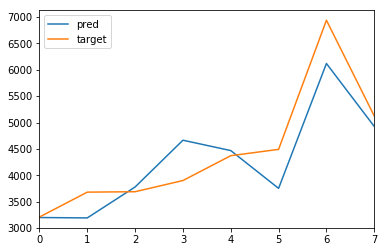

In [28]:
graph_results = result[['pred','target']].plot()
graph_results

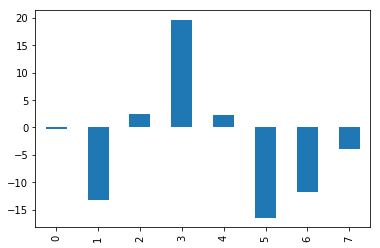

In [27]:
percent_diff = result['percent_diff'].plot.bar()
percent_diff